In [1]:
!pip install -q torchinfo

# Fashion MNIST Classification with MLP (Multi Layer Perceptron)

In this notebook, I am going to build MLP model for image classification on Fashion Mnist dataset which is also part of the `torchvision.datasets. The dataset has 10 classes as I show in the following. Even though Multi Layer Perceptron are not work and and popular in real world use, I somehow manage to try to build this as part of my **PyTorch BootCamp From OpenCV**. The instructor said that the MLP models mostly use for regression problems eg. house price predictions.
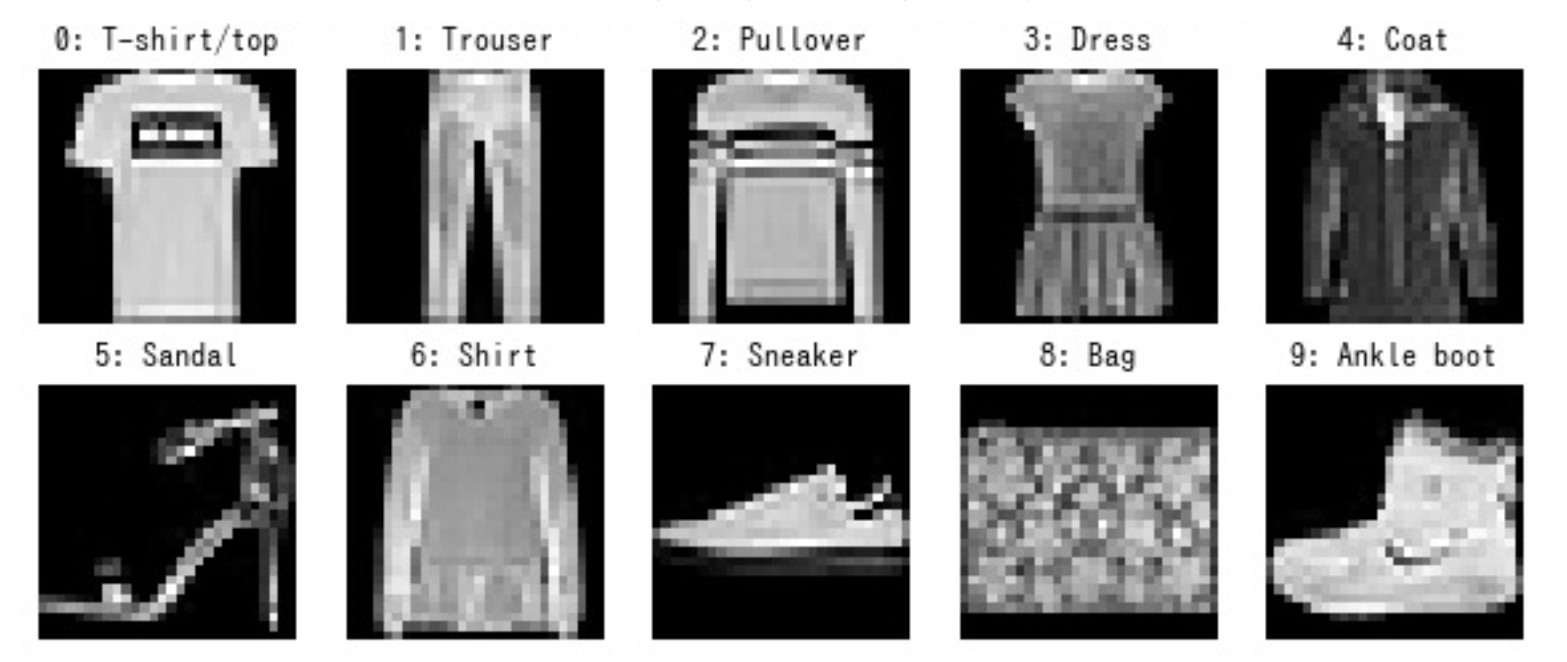

In [2]:
import torch
from torchvision import datasets, transforms

# Load the Fashion MNIST dataset (without normalization)
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Stack all images into a single tensor and compute mean and std
all_pixels = torch.cat([img.view(-1) for img,_ in dataset])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]


Mean: 0.2860, Std: 0.3530


In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Set Seed for reproducibility

In [4]:
def set_seeds():
  SEED_VALUE =42

  random.seed(SEED_VALUE)
  np.random.seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  # Fix seed to make training deterministic
  if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic= True
    torch.backends.cudnn.benchmark =True


set_seeds()

## Prepare the dataloader

- In Training, we don't actuall passed all the 60,000 images, we just make batches and pass batch by batch to the model during the training. After one batch complete, we said `one iteration` complete and after the completion of all batches (aka iteraions ) then we meant `one epoch` complete.
- Since we are now working with images as the input, we need to find some logical way to represent the image data as a set of features. A naive approach that actually works fairly well for this dataset is to just assume that the pixel intensities are the features. And one way to transform the image data into a set of features that we can process is to flatten the 2D array into a 1D array. The 28x28 input image thus becomes a 1D array containing 784 features. Notice that
- Also normalize the pixel intensities to be in the range [0, 1]. This is very common when working with image data which helps the model train more efficiently. - Also, using the pixel intensities as features is a naive approach .

In [5]:
# Download the training set withou normalization
raw_transform = transforms.Compose([transforms.ToTensor()])
train_set_raw = datasets.FashionMNIST(root = "F_MNIST_data",download=True, train=True, transform = raw_transform)

# flatten to 1D to compute mean and std
all_pixels = torch.cat([img.view(-1) for img,_ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Computed Mean: {mean:.4f}, Computed Std: {std:.4f}")

# Define new transform using mean and std to normalize 0 to 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))
])

# Reload the dataset with proper normalization
train_set = datasets.FashionMNIST(root ="F_MNIST_data", download=True, train=True, transform= transform)
val_set =datasets.FashionMNIST(root="F_MNIST_data", download= True, train=False, transform = transform)

print("Total Train Images", len(train_set))
print("Total Val Images", len(val_set))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.6MB/s]


Computed Mean: 0.2860, Computed Std: 0.3530
Total Train Images 60000
Total Val Images 10000


In [6]:
# make the batch size=64, 64 images at a iteratioin
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size= 64 )
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=64)


In [7]:
# Class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

## Dataset Visualization

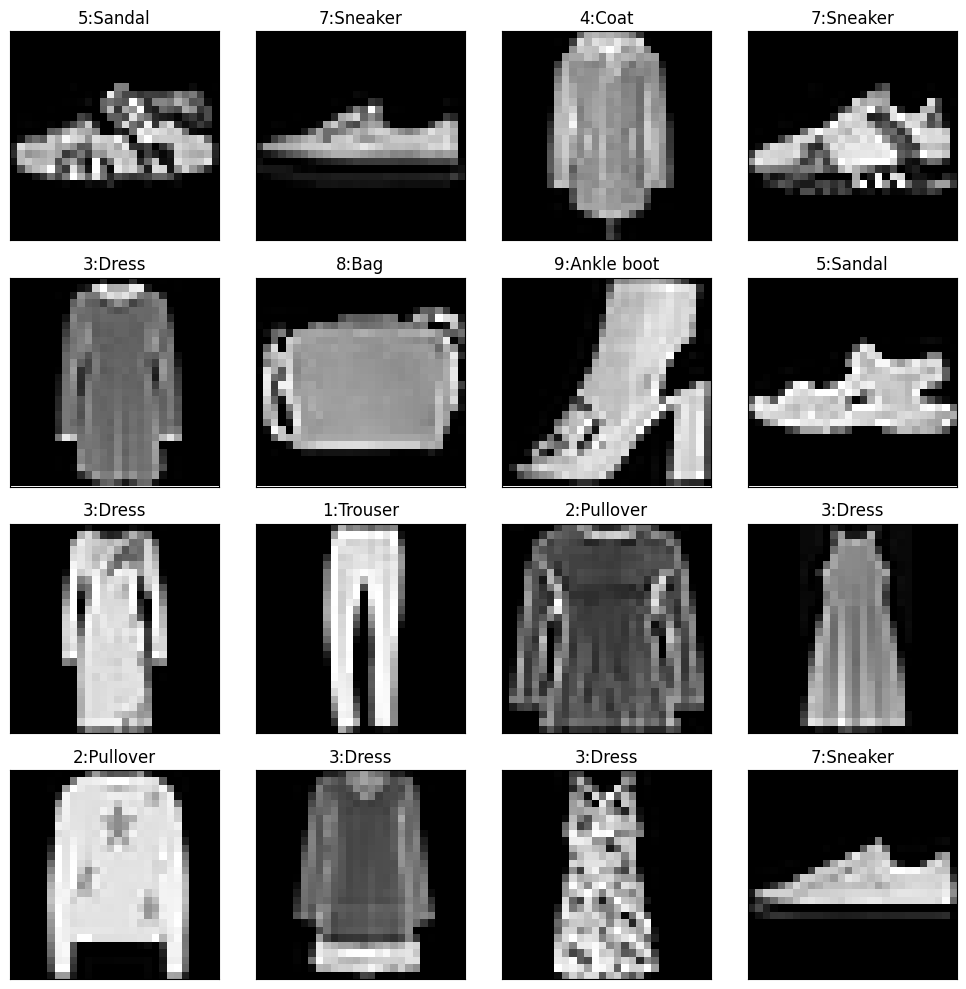

In [8]:
def visualize_images(trainloader, num_images=20):
  fig = plt.figure(figsize=(10,10))

  # Iterate over the first batch
  images, labels = next(iter(trainloader))

  # To calculate the number of rows and columns for subplots
  num_rows = 4
  num_cols =int(np.ceil(num_images/num_rows))

  for idx in range(min(num_images, len(images))):
    image , label = images[idx], labels[idx]

    axis = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[],
                           yticks=[])

    axis.imshow(np.squeeze(image),cmap="gray")
    axis.set_title(f"{label.item()}:{class_mapping[label.item()]}")

  fig.tight_layout()
  plt.show()

visualize_images(train_loader, num_images=16)

## Model Architecture
### Deep Neural Network Architecture

The network architecture shown below has multiple layers. An input layer, five hidden layers, and an output layer.
1. Input Data: The image input data is pre-processed (flattened) from a 2-Dimensional array [28,28] to 1-Dimentional vectore of length [784,1] where the elements in this input vector are the normalized pixel intensities.

2. Hidden Layers: Five hidden layers that contain some number of neurons. Each of the neurons in these layers has a non-linear activation function (eg. **ReLU**, **Sigmoid**, etc.)

3. Output Layer: Now have ten neurons in the output layer to represnt the ten different classes ( cloth items: 0 to 9 ).

4. Dense Layer: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The **weights** associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.

5. Softmax Function : The values from each of the neurons in the output layer are passed thru a `log_softmax()` function to produce a probability score for each of the ten cloth items in the dataset.

6. Network Output: The network output `($y’$)`, is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing `($y'$)` through the argmax function to determine the index of the predicted label.

Loss Function: The loss function used is **Negative Log Likelihood Loss(NLL)**. It is computed from the ground truth labels `($y$)` and the output log probabilities of the network `($y'$).` Note that $y$ and $y'$ are both matrices whose shape is (Bacth Size, Num Classes).

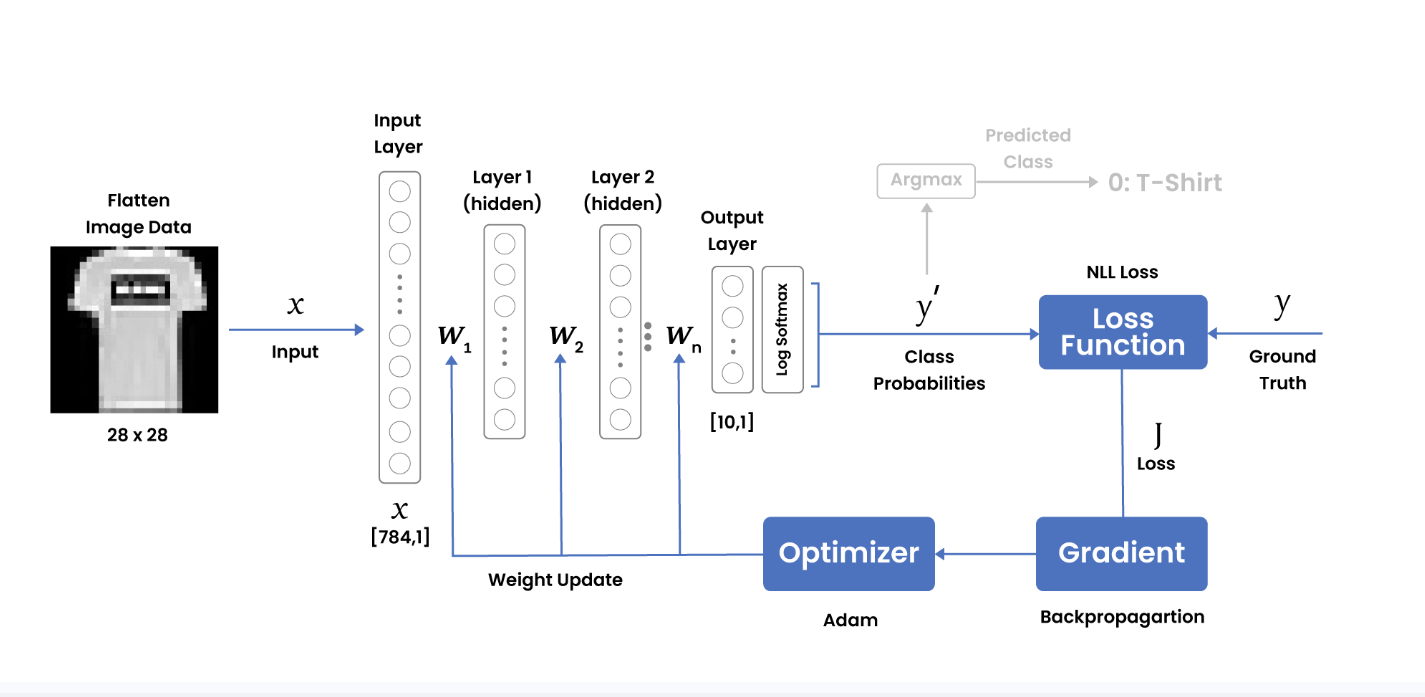

## Multi Layer Perceptron Model Implementation

- MLP model for classifying 10 classes using PyTorch `nn` Module. The model consists of `Five` Fully Connected Layers with `ReLU` Activations, batch normalization, and droput for regularization.

- Input Layer processes 28x28 images (flattened to 784 features),and the output layer uses a `log-softmax` activation function to produce probabilities for 10 classes

In [55]:
class MLP(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # linearity Wx+b
    self.fc0 = nn.Linear(784, 512)
    # batch normalization for regularization
    self.bn0 = nn.BatchNorm1d(512)

    self.fc1 = nn.Linear(512,  256)
    self.bn1 = nn.BatchNorm1d(256)

    self.fc2 = nn.Linear(256, 128)
    self.bn2 = nn.BatchNorm1d(128)

    self.fc3 = nn.Linear(128, 64)
    self.bn3 = nn.BatchNorm1d(64)

    self.fc4 = nn.Linear(64, num_classes)
    self.dropout = nn.Dropout(p=0.5)

  # Forward Pass of x (input)
  def forward(self, x):
    # Flatten the input tensor
    x = x.view(x.shape[0], -1) #(B,784) --> 28x28 = 784

    # First fully connected layer with relu, batchnorm and dropout
    x = F.relu(self.bn0(self.fc0(x)))
    x = self.dropout(x)

    # Second fully connected layer with relu, batchnorm (no droput just with intuition hahaxD)
    x = F.relu(self.bn1(self.fc1(x)))

    # Third Fully connected layer with relu, batchnorm and dropout
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout(x)

    # Fourth Fully connected layer
    x = F.relu(self.bn3(self.fc3(x)))

    # Output Layer with softmax activation
    x = F.log_softmax(self.fc4(x), dim =1)


    return x


mlp_model = MLP(num_classes=10)

In [42]:
# Look at the parameters and output shape for each layers
# A dummpy input size of (B, C, H, W) = (1,1,28,28) is passed

print(summary(mlp_model, input_size =(1,1,28,28), row_settings=["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

## Training Configuration

In [24]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2) # 0.0|
num_epochs =40
DEVICE ="cuda" if torch.cuda.is_available() else "cpu"

## Model Training
For Training the model, input images, and the label has to be on the same devices, either on `cuda` or `cpu`.


In [31]:
def train(model, trainloader, criterion, optimizer, DEVICE):
  model.train()
  model.to(DEVICE)
  running_loss =0
  correct_predictions =0
  total_samples =0

  for images, labels in trainloader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted= torch.max(outputs.data, dim=1)
    total_samples += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

  avg_loss= running_loss/ len(trainloader)
  accuracy =100* correct_predictions/total_samples
  return avg_loss, accuracy


In [35]:
def validation(model, val_loader,criterion, DEVICE):
  model.eval()
  model.to(DEVICE)

  running_loss =0
  correct_predictions =0
  total_samples =0
  # with no gradient decent
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(DEVICE), labels.to(DEVICE)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data,1)
      total_samples+= labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

    avg_loss= running_loss/ len(val_loader)
    accuracy = 100*correct_predictions/ total_samples

  return avg_loss, accuracy




In [36]:
# Gonna train for 40 epochs and plot the training accuracy and loss.

def main(model ,train_loader, val_loader, epochs = 5, DEVICE="cuda",save_path = "best_model.pth"):
  # Train and val's accuracies and losses in list type to visualize
  train_losses , val_losses = [],[]
  train_accuracies , val_accuracies = [],[]
  best_val_acc =0.0
  for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader,criterion, optimizer, DEVICE)
    val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    # we gonna saved the best model to use later hee hee xD
    if val_accuracy > best_val_acc:
      best_val_acc = val_accuracy
      torch.save(model.state_dict(), save_path)
      print(f"Best model saved at epoch {epoch+1}")

    print(f"Epoch {epoch+1:0>2}/{epochs}- Train Loss {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


  print(f"\n Best Validation Accuracy: {best_val_acc:.2f}%")
  # Plotting Loss and accuracy
  plt.figure(figsize=(12,15))
  plt.subplot(1,2,1)
  plt.plot(range(1, epochs+1), train_losses,label= "Train Loss")
  plt.plot(range(1, epochs+1), val_losses, label= "Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(range(1, epochs+1), train_accuracies, label= "Train Accuracy")
  plt.plot(range(1, epochs+1), val_accuracies, label ="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.tight_layout()
  plt.show()

Best model saved at epoch 1
Epoch 01/40- Train Loss 0.2163, Train Accuracy: 92.05% | Val Loss: 0.2894, Val Accuracy: 90.08%
Epoch 02/40- Train Loss 0.2119, Train Accuracy: 92.20% | Val Loss: 0.2824, Val Accuracy: 89.86%
Epoch 03/40- Train Loss 0.2085, Train Accuracy: 92.39% | Val Loss: 0.2931, Val Accuracy: 89.91%
Best model saved at epoch 4
Epoch 04/40- Train Loss 0.2051, Train Accuracy: 92.45% | Val Loss: 0.2978, Val Accuracy: 90.11%
Epoch 05/40- Train Loss 0.2064, Train Accuracy: 92.47% | Val Loss: 0.2842, Val Accuracy: 90.10%
Epoch 06/40- Train Loss 0.2039, Train Accuracy: 92.58% | Val Loss: 0.2904, Val Accuracy: 90.09%
Epoch 07/40- Train Loss 0.2012, Train Accuracy: 92.58% | Val Loss: 0.2824, Val Accuracy: 90.11%
Best model saved at epoch 8
Epoch 08/40- Train Loss 0.1988, Train Accuracy: 92.73% | Val Loss: 0.2971, Val Accuracy: 90.37%
Best model saved at epoch 9
Epoch 09/40- Train Loss 0.1999, Train Accuracy: 92.60% | Val Loss: 0.2863, Val Accuracy: 90.65%
Epoch 10/40- Train Loss 

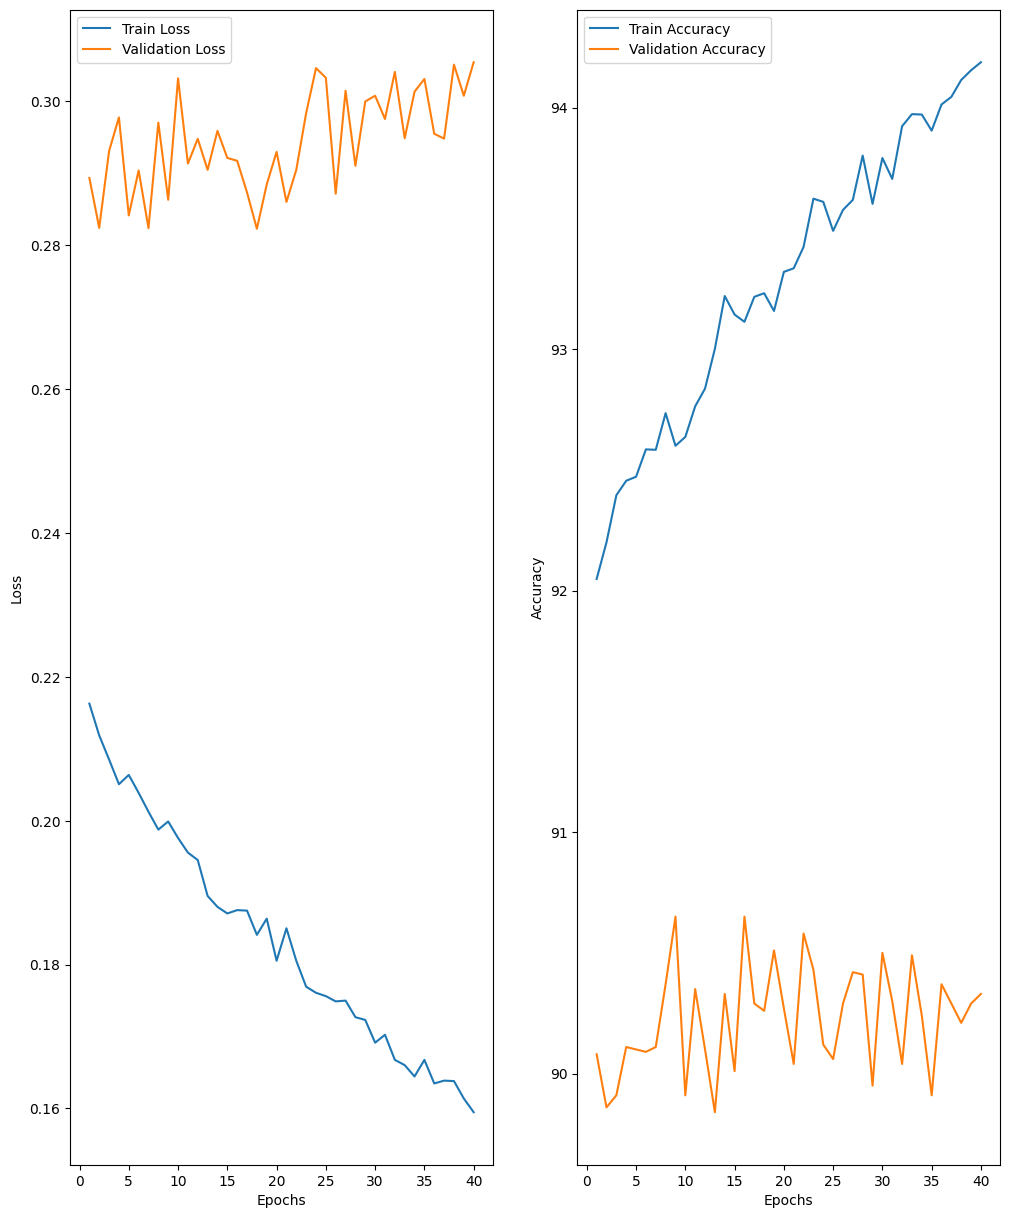

In [38]:
main(mlp_model, train_loader, val_loader, epochs= num_epochs, DEVICE=DEVICE)

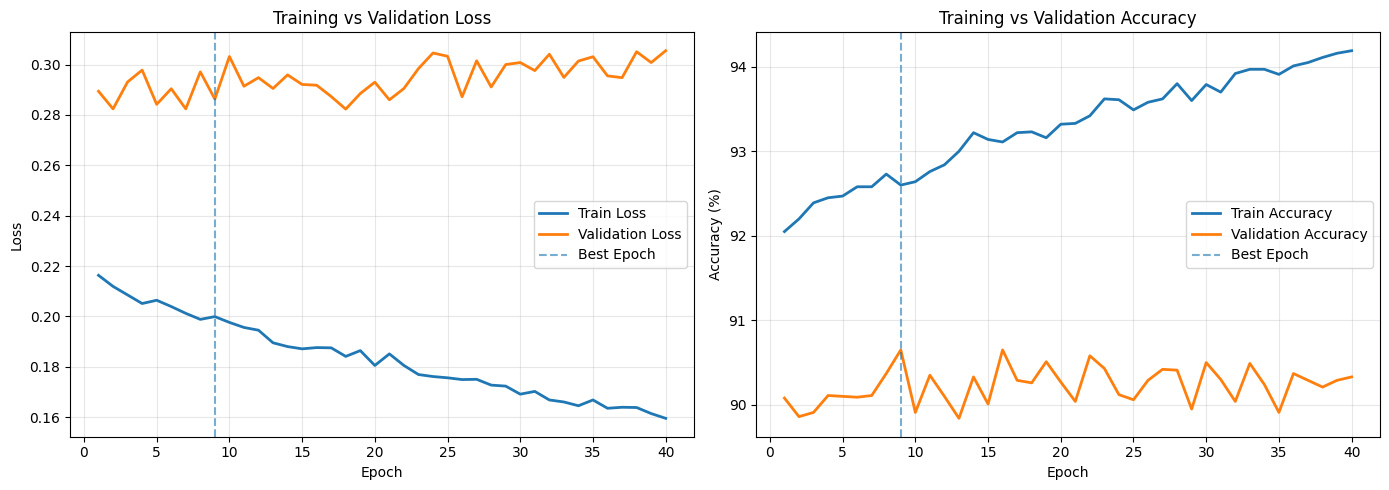

In [40]:
epochs = list(range(1, 41))

train_losses = [
    0.2163, 0.2119, 0.2085, 0.2051, 0.2064, 0.2039, 0.2012, 0.1988,
    0.1999, 0.1976, 0.1956, 0.1945, 0.1895, 0.1880, 0.1871, 0.1876,
    0.1875, 0.1841, 0.1864, 0.1805, 0.1851, 0.1805, 0.1769, 0.1761,
    0.1756, 0.1749, 0.1750, 0.1727, 0.1723, 0.1691, 0.1702, 0.1668,
    0.1660, 0.1645, 0.1668, 0.1635, 0.1639, 0.1638, 0.1614, 0.1595
]

val_losses = [
    0.2894, 0.2824, 0.2931, 0.2978, 0.2842, 0.2904, 0.2824, 0.2971,
    0.2863, 0.3032, 0.2914, 0.2948, 0.2905, 0.2959, 0.2921, 0.2918,
    0.2873, 0.2823, 0.2885, 0.2930, 0.2860, 0.2905, 0.2984, 0.3046,
    0.3033, 0.2872, 0.3015, 0.2911, 0.3000, 0.3008, 0.2976, 0.3041,
    0.2949, 0.3014, 0.3031, 0.2955, 0.2948, 0.3051, 0.3008, 0.3055
]

train_acc = [
    92.05, 92.20, 92.39, 92.45, 92.47, 92.58, 92.58, 92.73,
    92.60, 92.64, 92.76, 92.84, 93.00, 93.22, 93.14, 93.11,
    93.22, 93.23, 93.16, 93.32, 93.33, 93.42, 93.62, 93.61,
    93.49, 93.58, 93.62, 93.80, 93.60, 93.79, 93.70, 93.92,
    93.97, 93.97, 93.91, 94.01, 94.05, 94.11, 94.16, 94.19
]

val_acc = [
    90.08, 89.86, 89.91, 90.11, 90.10, 90.09, 90.11, 90.37,
    90.65, 89.91, 90.35, 90.10, 89.84, 90.33, 90.01, 90.65,
    90.29, 90.26, 90.51, 90.27, 90.04, 90.58, 90.43, 90.12,
    90.06, 90.29, 90.42, 90.41, 89.95, 90.50, 90.30, 90.04,
    90.49, 90.24, 89.91, 90.37, 90.29, 90.21, 90.29, 90.33
]



import matplotlib.pyplot as plt

best_epoch = 9   # highest val accuracy ≈ 90.65%

plt.figure(figsize=(14, 5))

# ---- Loss subplot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
plt.axvline(best_epoch, linestyle="--", alpha=0.6, label="Best Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

# ---- Accuracy subplot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2)
plt.axvline(best_epoch, linestyle="--", alpha=0.6, label="Best Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Inference Result

As we saved the best model in the training process, so we gonna load the model to use and make inference to see how's the model going on.



In [43]:
mlp_model.load_state_dict(torch.load("best_model.pth",map_location=DEVICE))
mlp_model.to(DEVICE)
mlp_model.eval()

MLP(
  (fc0): Linear(in_features=784, out_features=512, bias=True)
  (bn0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [48]:
# Visualize 5 images with our model

import random
import numpy as np

def show_predictions(model, val_loader, class_names, DEVICE="cuda", num_images=5):
    model.eval()

    images, labels = next(iter(val_loader))

    idxs = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(15,4))

    for i, idx in enumerate(idxs):
        img = images[idx].unsqueeze(0).to(DEVICE) #(1,1,28,28)
        label = labels[idx].item()

        with torch.no_grad():
            outputs = model(img)
            probs = torch.softmax(outputs, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            confidence = probs[0, pred].item() * 100

        img_np = images[idx].squeeze().cpu().numpy()

        plt.subplot(1, num_images, i+1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(
            f"GT: {class_names[label]}\nPred: {class_names[pred]} ({confidence:.1f}%)",
            color="green" if pred == label else "red"
        )

    plt.show()


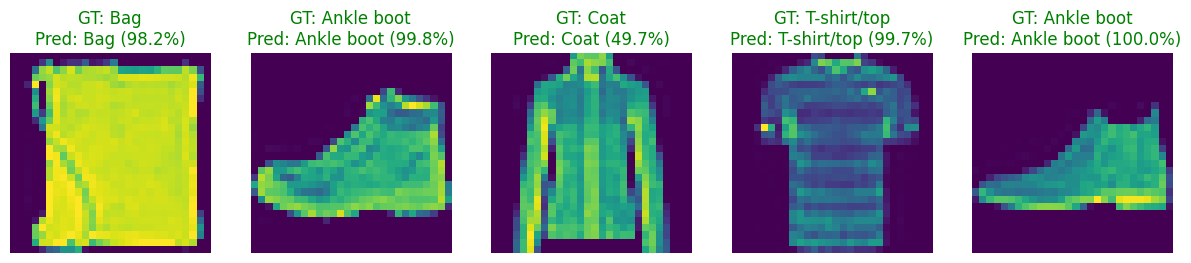

In [50]:
show_predictions(mlp_model, val_loader, class_mapping)

## Confusin Matrix

A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts).

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [52]:

def get_all_preds(model, dataloader, DEVICE="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)             # log-probs
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_labels), torch.cat(all_preds)

In [53]:
def plot_confusion_matrix(y_true, y_pred, class_mapping):
    cm = confusion_matrix(y_true, y_pred)

    class_names = [class_mapping[i] for i in range(len(class_mapping))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


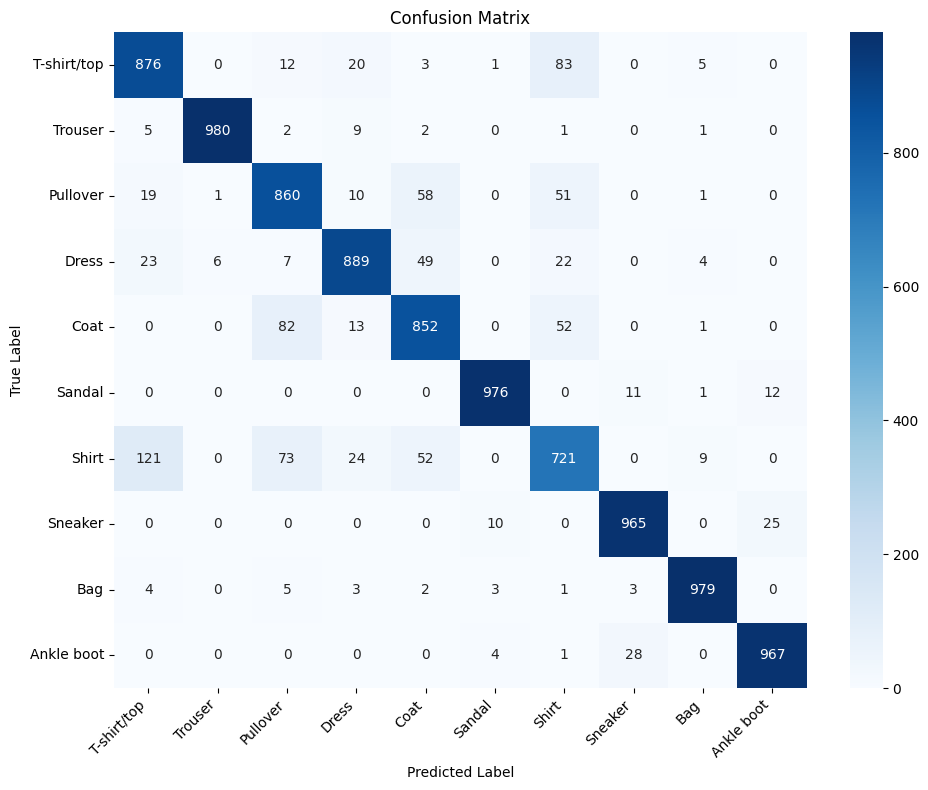

In [54]:
y_true, y_pred = get_all_preds(mlp_model, val_loader, DEVICE)
plot_confusion_matrix(y_true, y_pred, class_mapping)


# Model Performance Comparison: Effect of Dropout Rate

In this experiment, I modified the dropout rate used in the neural network architecture and compared the results with the instructor’s baseline model. While the instructor used a dropout value of **0.3**, I increased the dropout rate to **0.5** in my model to encourage stronger regularization and reduce overfitting.

Both models were trained for **40 epochs** under the same training conditions. The instructor’s model achieved a **best validation accuracy of 90.37%**, whereas my model reached a slightly higher **best validation accuracy of 90.67%**. This indicates that increasing the dropout rate had a positive, though modest, impact on the overall generalization performance of the model.

Beyond overall accuracy, a class-wise performance comparison shows that the two models behave differently across certain categories. In particular, my model demonstrates improved performance in identifying **Shirt** and **Coat** classes. For the **Shirt** class, my model correctly classified **721 samples**, compared to **689 samples** in the instructor’s model. Similarly, for the **Coat** class, my model achieved **852 correct predictions**, outperforming the instructor’s **808 correct predictions**.

**P.S** Idk why the graph plotting immediately after the training looks weird. I think maybe because of not specifying `plt.tightlayout()`.
